# Calculate diversity of generations
From paper, page 9:

The diversity is measured using the average overlap of the longest sub-sequence (LCS) among sampled answers:

\begin{equation}
1 - \frac{1}{\binom{M}{2}} \sum_{s \neq s' \in C} \text{ROUGE-L}(s, s') 
\end{equation}

$\binom{M}{2}$ is the number of possible pairs of $s \neq s'$ (order doesn't matter)


1) Calculate diversity of 5 groups 
2) For multinomial sampling and multinomial beam sampling

In [30]:
import glob
import pickle
from itertools import combinations
from rouge_score import rouge_scorer
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
def diversity(string_list):
    rouge_l_sum = 0
    n_pairs = 0

    for s, s_prime in combinations(string_list, 2):
        rouge_l_sum += scorer.score(s, s_prime)["rougeL"].fmeasure
        n_pairs += 1

    return 1 - rouge_l_sum / n_pairs

In [3]:
def load_pickle_files(folder):
    data_groups = []
    pickle_files = glob.glob(f"{folder}/group*.pkl")
    for pickle_file in pickle_files:
        with open(pickle_file, "rb") as f:
            data_groups.append(pickle.load(f))

    return data_groups

In [4]:
# https://thepythoncode.com/article/calculate-rouge-score-in-python#rouge-l
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

save_path = config["path_to_saved_generations"]
data_groups = load_pickle_files(save_path)

keys_data = [f"temperature_{temp}" for temp in config["temperatures"]] + [f"beam_{beam}" for beam in config["n_beams"]]
diversity_scores = {k: [] for k in keys_data}

In [5]:
for data in data_groups:
    group_diversity_scores = {k: [] for k in keys_data}
    for question_idx in data.keys():
        for k in keys_data:
            answers = data[question_idx][k]["answers"]
            group_diversity_scores[k].append(diversity(answers))

    # Add mean diversity of group to diversity_scores
    diversity_scores = {k: diversity_scores[k] + [np.mean(group_diversity_scores[k])] for k in keys_data}

In [15]:
# Convert to pandas df
diversity = pd.DataFrame(diversity_scores,
                         index=pd.Index([f"group_{i}" for i in range(len(data_groups))]))
diversity.index.name = "group"
diversity.reset_index(inplace=True)
print("Diversity scores of sampled answers")
diversity

Diversity scores of sampled answers


,group,temperature_0.25,temperature_0.5,temperature_1,temperature_1.5,beam_20
0,group_0,0.369426,0.637823,0.886433,0.956363,0.599882
1,group_1,0.347955,0.618786,0.883092,0.958035,0.611705
2,group_2,0.353941,0.625156,0.885565,0.959431,0.609484
3,group_3,0.356296,0.622342,0.888287,0.961473,0.617475
4,group_4,0.350981,0.605766,0.877252,0.955160,0.611195


**Diversity Scores for multinomial beam sampling:**

Results from the paper:
- Page 15: "Beam search also generates much less diverse samples. We conjecture that multinomial beam search sampling focuses too much on the most likely sequences. The diversity of this beam search corresponds to the lowest temperature result."
- Page 16, Table 4: Multinomial beam search sampling leads to a diversity of answers of $0.258$

This is different to the results to the results I obtain. For me, it is approx. 0.61 (see below). This is more than twice as big. One reason for this could be that I am using 20 beams and take the 10 beams with the highest probability. In the paper they use 5 beams for each answer.

In [76]:
np.mean(diversity["beam_20"])

0.6099479605148326

## Visualize results
### Diversity increases with increasing temperature

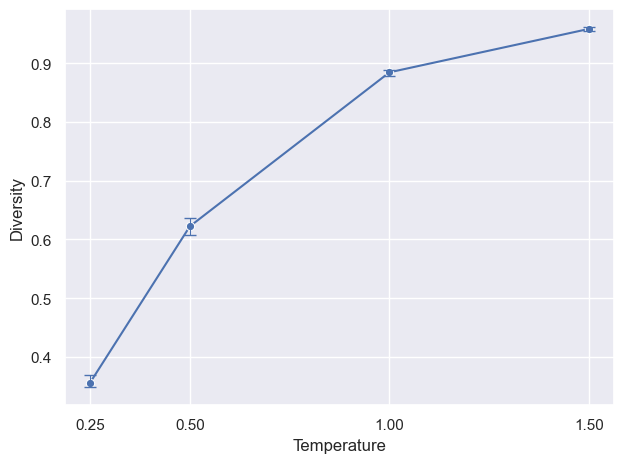

In [73]:
# Preprocessing
diversity_temperatures = diversity.drop(columns=diversity.filter(like="beam_").columns)
diversity_temperatures = pd.melt(diversity_temperatures, id_vars=["group"], value_name="diversity", var_name="temperature")
diversity_temperatures["group"] = diversity_temperatures["group"].str.replace("group_", "").astype(int)
diversity_temperatures["temperature"] = diversity_temperatures["temperature"].str.replace("temperature_", "").astype(float)

# Plot
plt.figure()
sns.lineplot(data=diversity_temperatures, x="temperature", y="diversity", errorbar="pi", estimator="mean", marker="o", err_style="bars", err_kws={"capsize": 4}, linewidth=1.5)
plt.xlabel("Temperature")
plt.ylabel("Diversity")
plt.xticks(config["temperatures"])
plt.tight_layout()
plt.show()

The results are similar to the ones in the paper (see Figure 3). In general, one can see that higher temperatures result in more diversity. In this plot, the diversity scores for the temperatures $0.25$ and $0.5$ are lower than in the paper. The reason for this could be the smaller model size. 

### Average correctness of sampled answers
Include the average correctness of sampled answers (also done in the paper, see page 9)

Similar results as in paper:
- Page 15: "Beam search also generates much less diverse samples. We conjecture that multinomial beam search sampling focuses too much on the most likely sequences. The diversity of this beam search corresponds to the lowest temperature result."
- Page 16, Table 4: Multinomial beam search sampling leads to a diversity of answers of $0.258$
- Page 9, Figure 3: "Higher temperatures result in more diversity but less accurate generations."
- Page 9: "Reducing the temperature improves the average correctness of the answer"
